# FAIR

This notebook gives some simple examples of how to run and use the Finite Amplitude Impulse Response (FAIR) model. 

The  Finite  Amplitude  Impulse  Response  (FAIR)  model  is  a  simple  climate model. It allows the user to prescribed CO$_2$ emissions or radiative forcing, non-CO$_2$ radiative forcing and climate and carbon cycle parameters in order to estimate global mean atmospheric CO$_2$ concentrations, radiative forcing and temperature anomalies.

It was developed by Richard Millar, Zebedee Nicholls, Pierre Friedlingstein and Myles Allen. The motivation for developing it and its formulation is documented in  a  paper  published  in  Atmospheric  Chemistry  and  Physics  in  2017 (doi:10.5194/acp-2016-405).

In [1]:
import fair
fair.__version__

'0.1.1.dev0'

In [2]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 16, 9

## Basic run
Here we show how FAIR can be run with step change CO$_2$ emissions and sinusoidal non-CO$_2$ forcing timeseries.

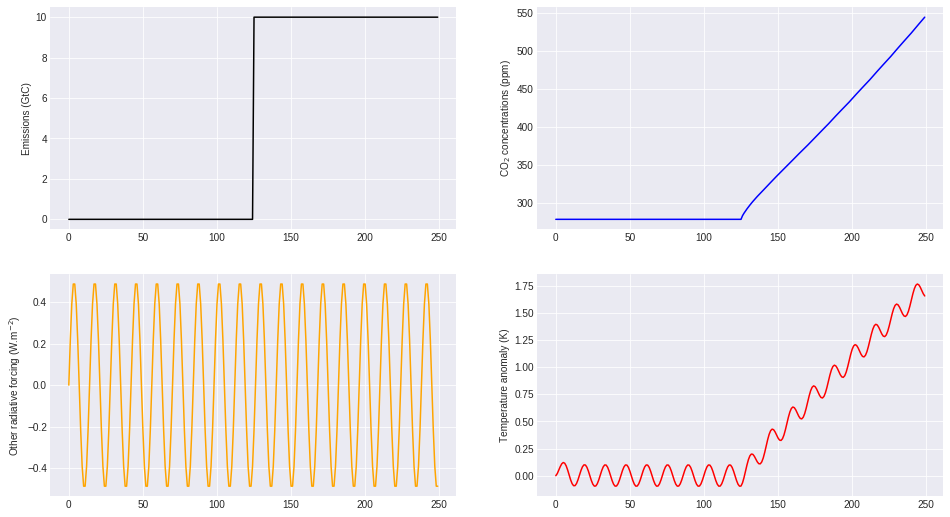

In [3]:
emissions = np.zeros(250)
emissions[125:] = 10.0
other_rf = np.zeros(emissions.size)
for x in range(0,emissions.size):
    other_rf[x] = 0.5*np.sin(2*np.pi*(x)/14.0)
    
C,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=other_rf)

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0,emissions.size),emissions,color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0,emissions.size),C,color='blue')
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0,emissions.size),other_rf,color='orange')
ax3.set_ylabel('Other radiative forcing (W.m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0,emissions.size),T,color='red')
ax4.set_ylabel('Temperature anomaly (K)')

## Emissions only
We can also run FAIR with just CO$_2$ emissions and no forcing.

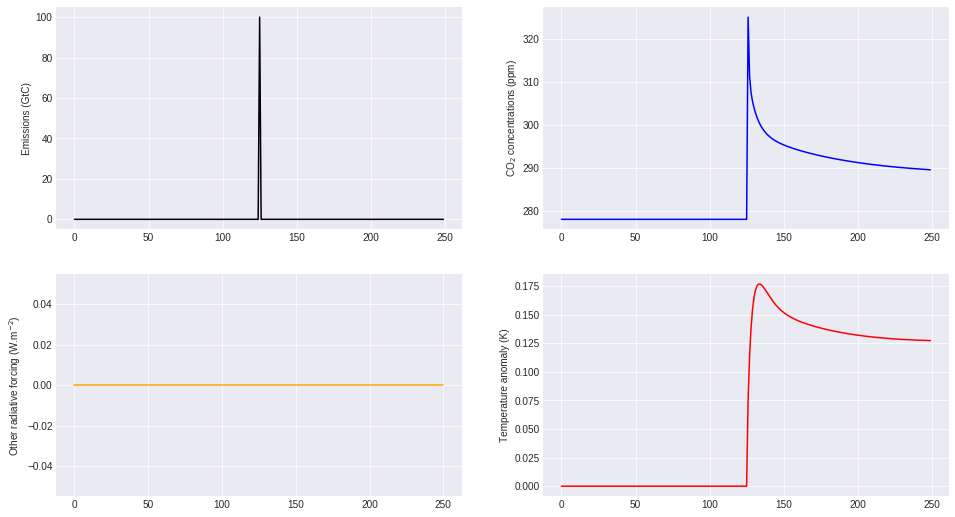

In [4]:
emissions = np.zeros(250)
emissions[125] = 100.0
other_rf = 0.0
C,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=other_rf)

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0,emissions.size),emissions,color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0,emissions.size),C,color='blue')
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot([0,emissions.size],[other_rf,other_rf],color='orange')
ax3.set_ylabel('Other radiative forcing (W.m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0,emissions.size),T,color='red')
ax4.set_ylabel('Temperature anomaly (K)')

## Forcing only
Or we can set emissions to zero and just have radiative forcing. Here we simply have a step change in radiative forcing from 0.0 W.m$^{-2}$ to RF$_{2 \times CO_2} = 3.74$ W.m$^{-2}$

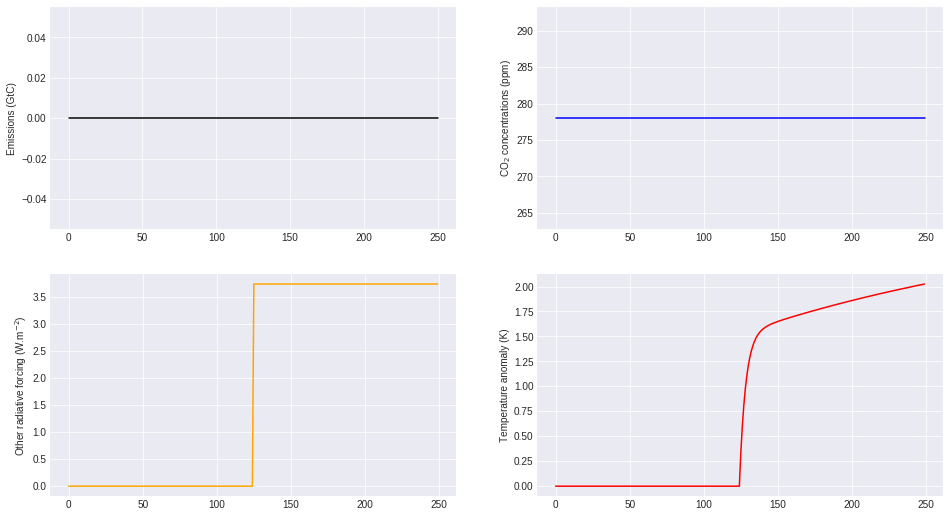

In [5]:
emissions = False
other_rf = np.zeros(250)
other_rf[125:] = 3.74

C,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=other_rf)
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot([0,other_rf.size],[0.0,0.0],color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0,other_rf.size),C,color='blue')
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot(range(0,other_rf.size),other_rf,color='orange')
ax3.set_ylabel('Other radiative forcing (W.m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0,other_rf.size),T,color='red')
ax4.set_ylabel('Temperature anomaly (K)')

## Timestepping

Here we use the timestepping capability built into FAIR to see what happens if we apply a simple criteria to emissions in each year based off observed warming to date.

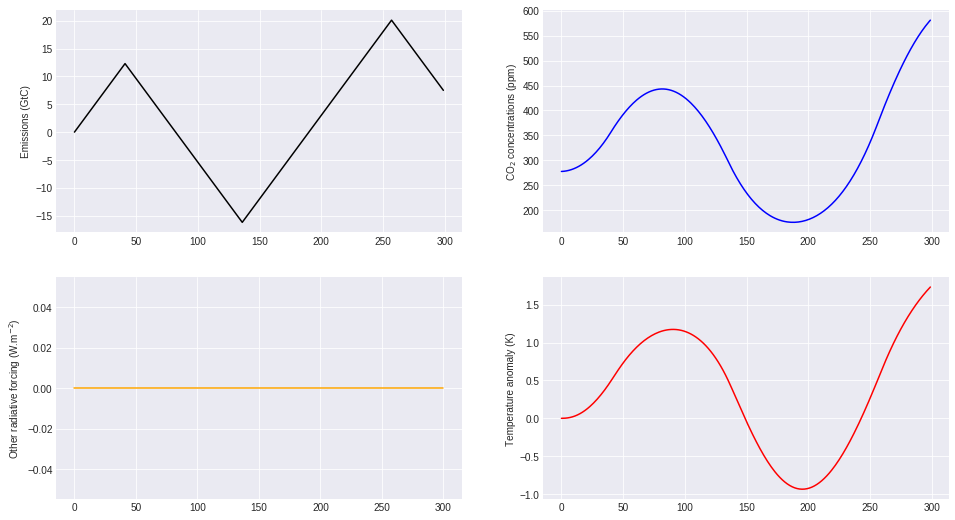

In [6]:
emissions = np.array([0.0])
other_rf = 0.0
restart = ([0.0,0.0,0.0,0.0],[0.0,0.0],0.0)

# start lists to store output timeseries
allt_emissions = []
allt_concentrations = []
allt_temperature = []

for j in range(0,300):
    # make our decision about whether to emit more or less
    if (j>=1):
        if (T > 0.5):
            emissions[0] -= 0.3
        else:
            emissions[0] += 0.3
        
    # timestep FAIR
    C,T,restart = fair.forward.fair_scm(
                           emissions=emissions,
                           other_rf = other_rf,
                           restart_in=restart,
                           restart_out=True
                                        )
    # store the result
    allt_emissions.append(emissions[0])
    allt_concentrations.append(C)
    allt_temperature.append(T)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(range(0,len(allt_emissions)),allt_emissions,color='black')
ax1.set_ylabel('Emissions (GtC)')
ax2 = fig.add_subplot(222)
ax2.plot(range(0,len(allt_emissions)),allt_concentrations,color='blue')
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3 = fig.add_subplot(223)
ax3.plot([0,len(allt_emissions)],[0.0,0.0],color='orange')
ax3.set_ylabel('Other radiative forcing (W.m$^{-2}$)')
ax4 = fig.add_subplot(224)
ax4.plot(range(0,len(allt_emissions)),allt_temperature,color='red')
ax4.set_ylabel('Temperature anomaly (K)')

## RCPs

We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios

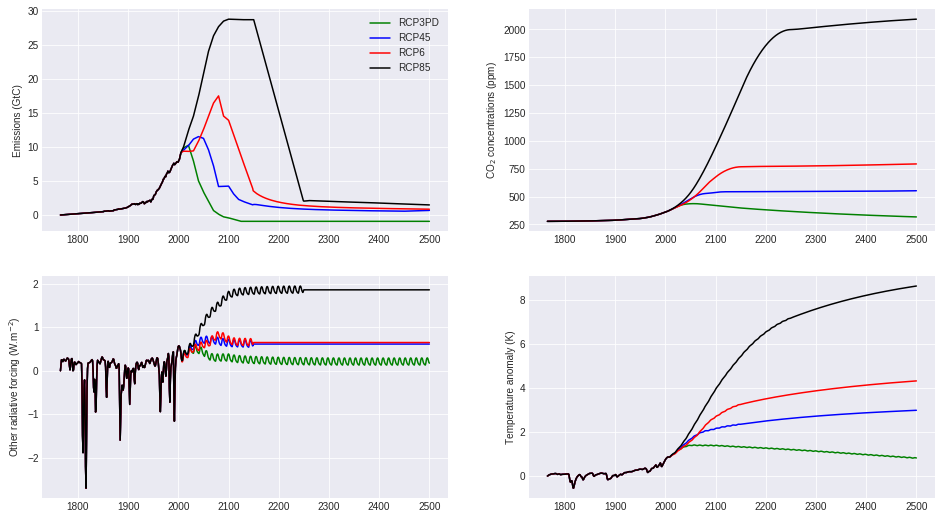

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

rcps = ['RCP3PD','RCP45','RCP6','RCP85']
colours = ['green','blue','red','black']
for i,rcp in enumerate(rcps):
    emms_file = './fair/RCPs/' + rcp + '_EMISSIONS.csv'
    emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)
    emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
    
    forc_file = './fair/RCPs/' + rcp + '_MIDYEAR_RADFORCING.csv'
    forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
    other_rf = forc_data['TOTAL_INCLVOLCANIC_RF'] - forc_data['CO2_RF']
    
    C,T = fair.forward.fair_scm(emissions=emissions,
                            other_rf=other_rf)
    
    ax1.plot(range(1765,1765+emissions.size),emissions,color=colours[i],label=rcp)
    ax2.plot(range(1765,1765+emissions.size),C,color=colours[i])
    ax3.plot(range(1765,1765+emissions.size),other_rf,color=colours[i])
    ax4.plot(range(1765,1765+emissions.size),T,color=colours[i])

ax1.set_ylabel('Emissions (GtC)')
ax1.legend()
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3.set_ylabel('Other radiative forcing (W.m$^{-2}$)')
ax4.set_ylabel('Temperature anomaly (K)')

## RCPs with uncertainty

We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios with an uncertainty plume for concentrations, temperature and radiative forcing highlighting high and low responses.

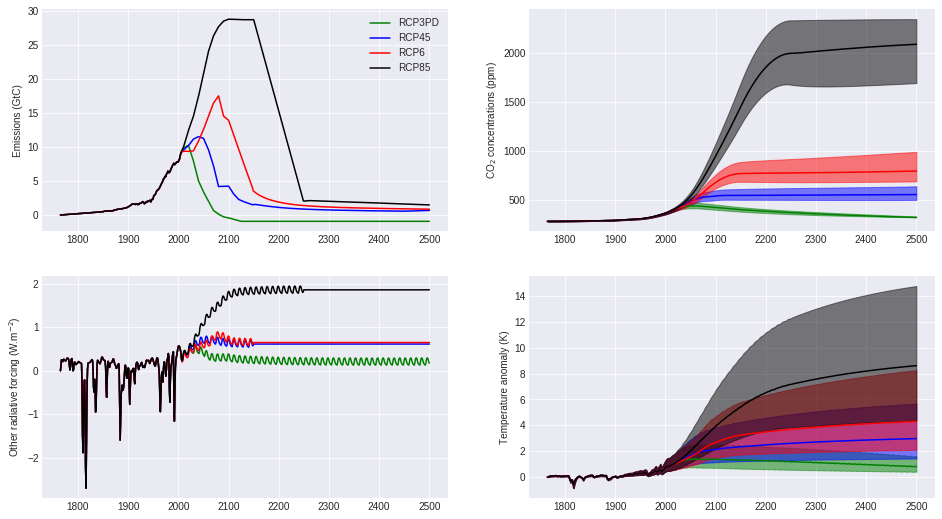

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

rcps = ['RCP3PD','RCP45','RCP6','RCP85']
colours = ['green','blue','red','black']

for i,rcp in enumerate(rcps):
    emms_file = './fair/RCPs/' + rcp + '_EMISSIONS.csv'
    emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)
    rcp_emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
    
    forc_file = './fair/RCPs/' + rcp + '_MIDYEAR_RADFORCING.csv'
    forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
    rcp_other_rf = forc_data['TOTAL_INCLVOLCANIC_RF'] - forc_data['CO2_RF']
    
    C_low,T_low = fair.forward.fair_scm(emissions=rcp_emissions,
                                        other_rf=rcp_other_rf,
                                        tcrecs=[1.0,1.5],
                                        r0=32.40*0.87,
                                        rc=0.019*0.87,
                                        rt=4.165*0.87,)
    C,T = fair.forward.fair_scm(emissions=rcp_emissions,
                                other_rf=rcp_other_rf,
                                tcrecs=[1.6,2.75],
                                r0=32.40,
                                rc=0.019,
                                rt=4.165,)
    C_high,T_high = fair.forward.fair_scm(emissions=rcp_emissions,
                                          other_rf=rcp_other_rf,
                                          tcrecs=[2.5,4.5],
                                          r0=32.40*1.13,
                                          rc=0.019*1.13,
                                          rt=4.165*1.13,)
    
    ax1.plot(range(1765,1765+emissions.size),rcp_emissions,color=colours[i],label=rcp)
    ax2.plot(range(1765,1765+emissions.size),C,color=colours[i])
    ax2.fill_between(range(1765,1765+emissions.size),
                     C_low,
                     C_high,
                     color=colours[i],
                     alpha=0.5)
    ax3.plot(range(1765,1765+emissions.size),rcp_other_rf,color=colours[i])
    ax4.plot(range(1765,1765+emissions.size),T,color=colours[i])
    ax4.fill_between(range(1765,1765+emissions.size),T_low,T_high,color=colours[i],alpha=0.5)

ax1.set_ylabel('Emissions (GtC)')
ax1.legend()
ax2.set_ylabel('CO$_2$ concentrations (ppm)')
ax3.set_ylabel('Other radiative forcing (W.m$^{-2}$)')
ax4.set_ylabel('Temperature anomaly (K)')